# Stochastic simulations for Bayesian IDM and Memory-Augmented (MA)-IDM (i.e., GP+IDM)

In this notebook, we are mainly comparing the simulation results among the hierachicle/pooled/unpooled MA-IDM/Bayesian IDM.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
import os
import sys
import numpy as np
import scipy
import CRPS.CRPS as pscore

sys.path.append('../')
from data.data_loader import read_training_data
from config import Config

## Visualize the data

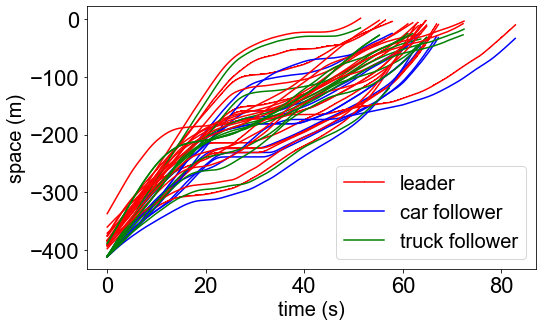

In [3]:
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

base_path = '../data/highD/'
tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)

figure = plt.figure(figsize=(8, 5))
for pair_id in Config.car_interactive_pair_list:
    x = tracks[pair_id]['xFollReal']
    x_leader = tracks[pair_id]['xLeaderReal']
    dt = Config.dt
    T = dt * np.array([range(x.shape[0])]).transpose()
    
    plt.plot(T,x,'-b')
    plt.plot(T,x_leader,'-,r')

plt.plot(T,x_leader,'-,r', label='leader')
plt.plot(T,x,'-b', label='car follower')

for pair_id in Config.truck_interactive_pair_list:
    x = tracks[pair_id]['xFollReal']
    x_leader = tracks[pair_id]['xLeaderReal']
    dt = Config.dt
    T = dt * np.array([range(x.shape[0])]).transpose()
    plt.plot(T,x,'-g')
    plt.plot(T,x_leader,'-r')

plt.plot(T,x,'-g', label='truck follower')

    
plt.xlabel('time (s)',fontsize=20)
plt.ylabel('space (m)',fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.tight_layout()
plt.show()
# figure.savefig('../Figs/show_data.pdf', dpi=300)

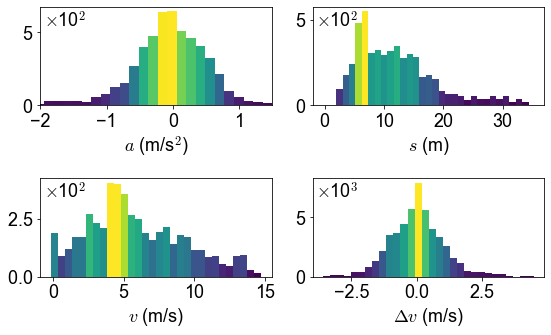

In [4]:
from matplotlib.ticker import PercentFormatter
from matplotlib import colors

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

base_path = '../data/highD/'
tracks = read_training_data(base_path=base_path, min_traj_lenth=50*Config.frame_rate_orignial)

for pair_id in Config.car_interactive_pair_list[0:8]:
    if pair_id==Config.car_interactive_pair_list[0]:
        sReal = tracks[pair_id]['sReal']
        dvReal = tracks[pair_id]['dvReal']
        vFollReal = tracks[pair_id]['vFollReal']
        aFollReal = tracks[pair_id]['aFollReal']
    else:
        sReal = np.concatenate((sReal, tracks[pair_id]['sReal']))
        dvReal = np.concatenate((dvReal, tracks[pair_id]['dvReal']))
        vFollReal = np.concatenate((vFollReal, tracks[pair_id]['vFollReal']))
        aFollReal = np.concatenate((aFollReal, tracks[pair_id]['aFollReal']))

for pair_id in Config.truck_interactive_pair_list[0:8]:
    sReal = np.concatenate((sReal, tracks[pair_id]['sReal']))
    dvReal = np.concatenate((dvReal, tracks[pair_id]['dvReal']))
    vFollReal = np.concatenate((vFollReal, tracks[pair_id]['vFollReal']))
    aFollReal = np.concatenate((aFollReal, tracks[pair_id]['aFollReal']))
    
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(8, 5))

##################
N, bins, patches = axs[0,0].hist(aFollReal, bins=30, density=False, label='a')
fracs = N / N.max()
# we need to normalize the data to 0~1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

##################
N, bins, patches = axs[0,1].hist(sReal,bins=30, density=False, label='s')
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

##################
N, bins, patches = axs[1,0].hist(vFollReal,bins=30, density=False, label='v')
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

##################
N, bins, patches = axs[1,1].hist(dvReal,bins=30, density=False, label='dv')
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs[0,0].set_xlim([-2,1.5])
axs[0,1].set_xlim([-2,37])

axs[0,0].set_xlabel('$a$ (m/s$^2$)')
axs[0,1].set_xlabel('$s$ (m)')
axs[1,0].set_xlabel('$v$ (m/s)')
axs[1,1].set_xlabel('$\Delta v$ (m/s)')


axs[0,0].ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(10,100))
axs[0,1].ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(10,100))
axs[1,0].ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(10,100))
axs[1,1].ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(10,100))


for i, axes in enumerate(axs.flat):
    axes.get_yaxis().get_offset_text().set_visible(False)
    ax_max = max(axes.get_yticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    axes.annotate(r'$\times$10$^{%i}$'%(exponent_axis),
                 xy=(.016, .8), xycoords='axes fraction')


plt.tight_layout()
plt.show()
# fig.savefig('../Figs/data_histogram.pdf', dpi=300)

## Illustrate the non-i.i.d. issue

Load trace ../PGM_highD/cache/MA_IDM_unpooled_truck.pkl : done!


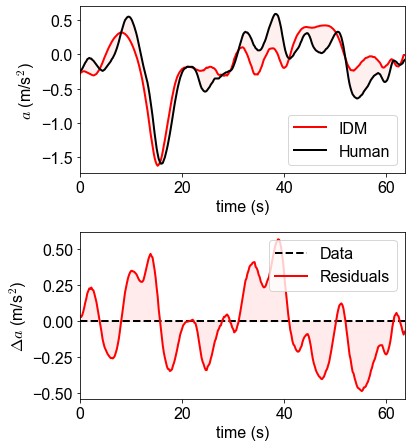

In [5]:
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a

def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt

def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt


def regression(tr, sample_idx, print_values=False, mean=False):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)
    pair_id = Config.truck_interactive_pair_list[0]
    if mean:
        driver_para = tr.posterior.mu.to_numpy()[:,:,:].mean(axis=0).mean(axis=0)
    else:
        driver_para = tr.posterior.mu.to_numpy()[:,sample_idx,:].mean(axis=0)

    DELTA = 4 
    
    if print_values:
        print("Loading parameters for driver", str(pair_id))
        print(driver_para)

    x_leader, v_leader = tracks[pair_id]['xLeaderReal'], tracks[pair_id]['vLeaderReal']

    x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'], \
                tracks[pair_id]['vFollReal'], tracks[pair_id]['aFollReal'], tracks[pair_id]['vehicle_length']

    s_real = tracks[pair_id]['sReal']

    N = x_leader.shape[0]

    T = np.array(range(0, N))*Config.dt

    x_follower_temp = x_follower[0]
    v_follower_temp = v_follower[0]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[0] = v_follower_temp
    s_follower_sim[0] = s_real[0]

    for t in range(1, N):
        x_leader_temp = x_leader[t-1]
        v_leader_temp = v_leader[t-1]

        s = s_real[t-1]
        vt = v_follower[t-1]
        dv = v_follower[t-1] - v_leader[t-1]

        a_follower_temp = IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv)
        v_follower_temp = IDM_v(a_follower_temp, vt)
        x_follower_temp  = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t-1] = a_follower_temp

    a_follower_sim[-1] = a_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T

base_path = '../data/highD/'

cache = "../PGM_highD/cache/MA_IDM_unpooled_truck.pkl"
fp = open(cache, 'rb')
tr_GP = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")


fig, _ = plt.subplots(ncols=1, sharex=True, figsize=(6, 6.5))

linewidth_mean = 2
color_sim_mean = 'red'

a_follower_sim_mean_GP, a_follower, v_follower_sim_mean_GP, v_follower, s_follower_sim_mean_GP, s_real, T = regression(tr_GP, 0, mean=True)

ax1 = plt.subplot(2,1,1)
plt.plot(T,a_follower_sim_mean_GP,'-', color=color_sim_mean, label='IDM', linewidth=linewidth_mean, alpha=1)
plt.plot(T,a_follower,'k-', label='Human', linewidth=linewidth_mean, alpha=1)
ax1.fill_between(T, a_follower, a_follower_sim_mean_GP, color='red', alpha=.06)
plt.xlabel('time (s)')
plt.ylabel('$a$ (m/s$^2$)')
plt.legend(loc='lower right')

ax2 = plt.subplot(2,1,2)
plt.plot(T, np.zeros_like(T), '--', color='k', label='Data', linewidth=linewidth_mean, alpha=1)
plt.plot(T,a_follower - a_follower_sim_mean_GP,'-', color=color_sim_mean, label='Residuals', linewidth=linewidth_mean, alpha=1)
ax2.fill_between(T, a_follower - a_follower_sim_mean_GP, 0, color='red', alpha=.08)
plt.xlabel('time (s)')
plt.ylabel('$\Delta a$ (m/s$^2$)')
plt.legend(loc='upper right')

ax1.set_xlim((0,T.max()))
ax2.set_xlim((0,T.max()))

plt.tight_layout()
# fig.savefig('../Figs/noniid.pdf', dpi=300)
plt.show()

# Hierarchical MA-IDM (GP+IDM) v.s. Bayesian IDM

## Stochastic simulations

Load trace ../PGM_highD/cache/MA_IDM_hierarchical.pkl : done!
Load trace ../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl : done!
Load tracks ../Simulator/cache/Hierarchical-sim-11-1000.pkl : done!
Simulation: 50 / 1000
Simulation: 100 / 1000
Simulation: 150 / 1000
Simulation: 200 / 1000
Simulation: 250 / 1000
Simulation: 300 / 1000
Simulation: 350 / 1000
Simulation: 400 / 1000
Simulation: 450 / 1000
Simulation: 500 / 1000
Simulation: 550 / 1000
Simulation: 600 / 1000
Simulation: 650 / 1000
Simulation: 700 / 1000
Simulation: 750 / 1000
Simulation: 800 / 1000
Simulation: 850 / 1000
Simulation: 900 / 1000
Simulation: 950 / 1000
Simulation: 1000 / 1000


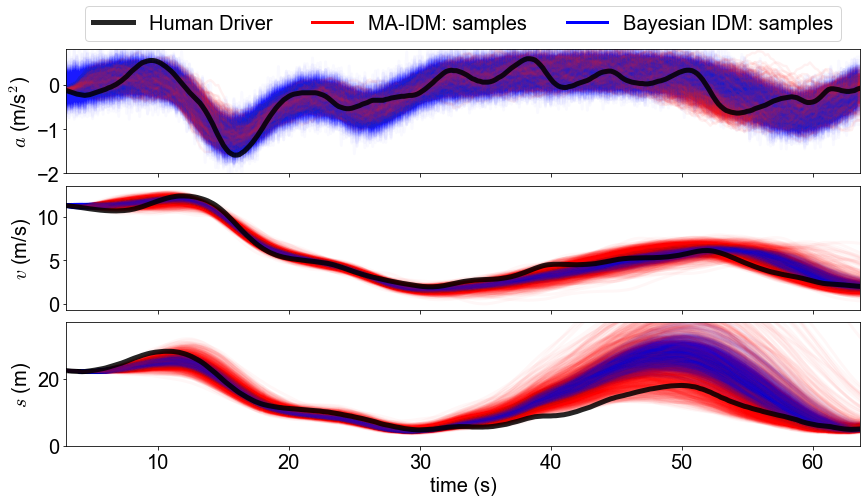

In [8]:
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import rbf_kernel

import pickle
from pickle import UnpicklingError
import os
from os import path

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

np.random.seed(seed=1116)

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a


def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt


def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt


# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1),
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)  + 1e-6 * np.eye(X1.shape[0])
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12).T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance


id_veh = 11


def simulate(tr, sample_idx, print_values=False, mean=False, GP_flag=False):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)
    if id_veh <= 10:
        
        pair_id = Config.car_interactive_pair_list[id_veh - 1]
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()
    else:
        pair_id = Config.truck_interactive_pair_list[id_veh - 1 - 10]
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()

    # Note that we have normalzied the IDM parameters when calibrating 
    driver_para *= [33, 2, 1.6, 1,5, 1.67]
    DELTA = 4

    if print_values:
        print("Loading parameters for driver", str(pair_id))
        print(driver_para)

    x_leader, v_leader = tracks[pair_id]['xLeaderReal'], tracks[pair_id]['vLeaderReal']

    x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'], \
                                                         tracks[pair_id]['vFollReal'], tracks[pair_id]['aFollReal'], \
                                                         tracks[pair_id]['vehicle_length']

    s_real = tracks[pair_id]['sReal']

    N = x_leader.shape[0]

    T = np.array(range(0, N)) * Config.dt

    x_follower_temp = x_follower[sample_dim]
    v_follower_temp = v_follower[sample_dim]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[:sample_dim + 1] = v_follower[:sample_dim + 1]
    s_follower_sim[:sample_dim + 1] = s_real[:sample_dim + 1]
    a_follower_sim[:sample_dim] = a_follower[:sample_dim]

    if GP_flag:
        l = tr.posterior.l.mean(axis=0).mean(axis=0).to_numpy()
        s_f = np.sqrt(tr.posterior.s2_f.mean(axis=0).mean(axis=0)).to_numpy()

        def RBF_kernel(XA, XB, l=l, A=s_f):
            X_dist = A ** 2 * rbf_kernel(XA[:, [0]], XB[:, [0]], gamma=0.5 / l ** 2)
            return X_dist

        X1 = np.expand_dims(np.linspace(-sample_dim, -1, sample_dim), 1)
        y1 = a_follower[:sample_dim] - \
             IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA,
                   s_real[:sample_dim], v_follower[:sample_dim], v_follower[:sample_dim] - v_leader[:sample_dim])
        X2 = np.expand_dims(np.linspace(0, 1, 2), 1)

    for t in range(sample_dim + 1, N):
        x_leader_temp = x_leader[t - 1]
        v_leader_temp = v_leader[t - 1]

        s = x_leader_temp - x_follower_temp - vehicle_length[t - 1]
        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp

        if GP_flag:
            μ2, Σ2 = GP(X1, y1, X2, RBF_kernel)
            a_GP_sim = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=1)
            a_GP_sim_temp = a_GP_sim[0, 0] + np.random.normal(0, np.sqrt(tr.posterior.s2_a.mean(axis=0).mean(axis=0)))
        else:
            a_GP_sim_temp = np.random.normal(0, tr_B.posterior.s_a.mean())

        a_follower_temp = a_GP_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3],
                                                driver_para[4], DELTA, s, vt, dv)
        v_follower_temp = IDM_v(a_follower_temp, vt)
        x_follower_temp = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t - 1] = a_follower_temp

        if GP_flag:
            y1[:-1] = y1[1:]
            y1[-1] = a_GP_sim[0, 0]

    a_follower_sim[-1] = a_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T


base_path = '../data/highD/'

cache = "../PGM_highD/cache/MA_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_GP = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")
sample_dim = int(2 * tr_GP.posterior.l.mean(axis=0).mean(axis=0).to_numpy()) + 1

cache = "../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_B = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(12, 7))

print_values = False
sample_num = 1000
counter = 0

linewidth = 3.
linewidth_mean = 2
linewidth_gt = 5
color_sim = 'red'
color_sim_mean = 'yellow'
color_sim_B = 'blue'
color_sim_mean_B = 'fuchsia'
color_sim_gt = 'k'
alpha = 0.03


def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


a_follower_sim_mean_GP, a_follower, v_follower_sim_mean_GP, v_follower, s_follower_sim_mean_GP, s_real, T = simulate(
    tr_GP, 0, print_values, mean=True, GP_flag=True)
a_follower_sim_mean_B, _, v_follower_sim_mean_B, _, s_follower_sim_mean_B, _, _ = simulate(tr_B, 0, print_values,
                                                                                           mean=True)

cache = "../Simulator/cache/Hierarchical-sim-{:d}-{:d}.pkl".format(id_veh, sample_num)

if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tracks = pickle.load(fp)
        fp.close()
        print("Load tracks", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    tracks = [None] * sample_num

for sample_idx in np.random.choice(range(2000), sample_num, replace=False):  # range(sample_num):#
    if not path.exists(cache):
        a_follower_sim_GP, _, v_follower_sim_GP, _, s_follower_sim_GP, _, T = simulate(tr_GP, sample_idx, print_values,
                                                                                       mean=True, GP_flag=True)
        a_follower_sim_B, _, v_follower_sim_B, _, s_follower_sim_B, _, T = simulate(tr_B, sample_idx, print_values,
                                                                                    mean=True)

        tracks[counter] = {
            'a_follower_sim_GP': a_follower_sim_GP,
            'v_follower_sim_GP': v_follower_sim_GP,
            's_follower_sim_GP': s_follower_sim_GP,
            'a_follower_sim_B': a_follower_sim_B,
            'v_follower_sim_B': v_follower_sim_B,
            's_follower_sim_B': s_follower_sim_B,
        }
    else:
        a_follower_sim_GP = tracks[counter]['a_follower_sim_GP']
        v_follower_sim_GP = tracks[counter]['v_follower_sim_GP']
        s_follower_sim_GP = tracks[counter]['s_follower_sim_GP']
        a_follower_sim_B = tracks[counter]['a_follower_sim_B']
        v_follower_sim_B = tracks[counter]['v_follower_sim_B']
        s_follower_sim_B = tracks[counter]['s_follower_sim_B']

    counter += 1
    if counter % 1 == 0:
        plt.subplot(3, 1, 1)
        plt.plot(T, a_follower_sim_B, '-', color=lighten_color(color_sim_B, .9), linewidth=linewidth, alpha=.8 * alpha)
        plt.plot(T, a_follower_sim_GP, '-', color=lighten_color(color_sim, .9), linewidth=0.8 * linewidth,
                 alpha=2 * alpha)

    plt.subplot(3, 1, 2)
    plt.plot(T, v_follower_sim_GP, '-', color=color_sim, linewidth=linewidth, alpha=alpha)
    plt.plot(T, v_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=alpha)

    plt.subplot(3, 1, 3)
    plt.plot(T, s_follower_sim_GP, '-', color=color_sim, linewidth=linewidth, alpha=alpha)
    plt.plot(T, s_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=alpha)
    if counter % 50 == 0:
        print("Simulation:", counter, "/", sample_num)

if not path.exists(cache):
    output_file = open(cache, 'wb')
    pickle.dump(tracks, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

#########################################
plt.subplot(3, 1, 1)
plt.plot(T, a_follower, '-', color=color_sim_gt, label='Human Driver', linewidth=linewidth_gt, alpha=0.85)
plt.ylabel('$a$ (m/s$^2$)')

plt.subplot(3, 1, 2)
plt.plot(T, v_follower, '-', color=color_sim_gt, label='Human Driver', linewidth=linewidth_gt, alpha=0.85)
plt.ylabel('$v$ (m/s)')

plt.subplot(3, 1, 3)
plt.plot(T, s_real, '-', color=color_sim_gt, label='Human Driver', linewidth=linewidth_gt, alpha=0.85)
plt.xlabel('time (s)')
plt.ylabel('$s$ (m)')

plt.subplot(3, 1, 1)
plt.plot(0, 0, '-', color=color_sim, label='MA-IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0, 0, '-', color=color_sim_B, label='Bayesian IDM: samples', linewidth=linewidth, alpha=1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.43), fancybox=True, ncol=3)

plt.subplot(3, 1, 2)
plt.plot(0, 0, '-', color=color_sim, label='MA-IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0, 0, '-', color=color_sim_B, label='Bayesian IDM: samples', linewidth=linewidth, alpha=1)

plt.subplot(3, 1, 3)
plt.plot(0, 0, '-', color=color_sim, label='MA-IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0, 0, '-', color=color_sim_B, label='Bayesian IDM: samples', linewidth=linewidth, alpha=1)

ax1.set_xlim((3, T.max()))
ax2.set_xlim((3, T.max()))
ax3.set_xlim((3, T.max()))
ax1.set_ylim((-2, 0.8))
ax3.set_ylim((0, 37))

ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)

plt.tight_layout(h_pad=0.05, rect=(-0.018, -0.027, 1.069, 1.018))
# fig.savefig('../Figs/Hierarchical_sim_id{:d}.pdf'.format(id_veh), dpi=300)
plt.show()

## Relative spacing diagram

Load trace ../PGM_highD/cache/MA_IDM_hierarchical.pkl : done!
Load trace ../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl : done!
Load tracks ../Simulator/cache/Hierarchical-sim-11-1000.pkl : done!
Simulation: 100 / 1000
Simulation: 200 / 1000
Simulation: 300 / 1000
Simulation: 400 / 1000
Simulation: 500 / 1000
Simulation: 600 / 1000
Simulation: 700 / 1000
Simulation: 800 / 1000
Simulation: 900 / 1000
Simulation: 1000 / 1000


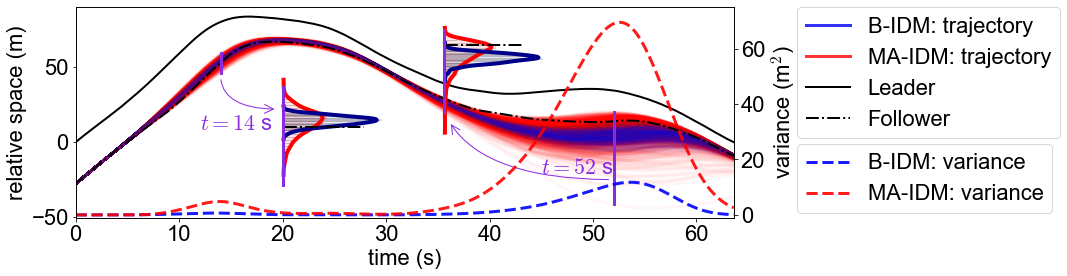

In [24]:
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import rbf_kernel

import pickle
from pickle import UnpicklingError
import os
from os import path
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

np.random.seed(seed=1116)

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a

def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt

def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt

def RBF_kernel(XA, XB, l=33, A=0.2):
    X_dist = A**2 * rbf_kernel(XA[:, [0]], XB[:, [0]], gamma=0.5 / l ** 2)
    return X_dist

# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12).T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

def simulate(tr, sample_idx, print_values=False, mean=False, GP_flag=False):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)

    pair_id = Config.truck_interactive_pair_list[0]
    if id_veh <= 10:
        pair_id = Config.car_interactive_pair_list[id_veh - 1]
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()
    else:
        pair_id = Config.truck_interactive_pair_list[id_veh - 1 - 10]
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()

    driver_para *= [33, 2, 1.6, 1.5, 1.67]
    DELTA = 4 
    
    if print_values:
        print("Loading parameters for driver", str(pair_id))
        print(driver_para)

    x_leader, v_leader = tracks[pair_id]['xLeaderReal'], tracks[pair_id]['vLeaderReal']

    x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'], \
                tracks[pair_id]['vFollReal'], tracks[pair_id]['aFollReal'], tracks[pair_id]['vehicle_length']

    s_real = tracks[pair_id]['sReal']

    N = x_leader.shape[0]

    T = np.array(range(0, N))*Config.dt

    x_follower_temp = x_follower[0]
    v_follower_temp = v_follower[0]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[0] = v_follower_temp
    s_follower_sim[0] = s_real[0]
    
    if GP_flag:
        # we select a window size of 2l = 66:
        sample_dim = 66
        
        t = np.array(range(-sample_dim, N)).reshape(-1,1)
        X1 = np.expand_dims(np.linspace(-sample_dim, 0, sample_dim), 1)
        y1 = np.zeros((sample_dim))
        X2 = np.expand_dims(np.linspace(0, N, N), 1)
        μ2, Σ2 = GP(X1, y1, X2, RBF_kernel)
        a_GP_sim = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=1)
        

    for t in range(1, N):
        x_leader_temp = x_leader[t-1]
        v_leader_temp = v_leader[t-1]

        s = x_leader_temp - x_follower_temp - vehicle_length[t-1]
        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp
        
        if GP_flag:
            a_GP_sim_temp = a_GP_sim[0,t-1] + np.random.normal(0,0.1)
        else:
            a_GP_sim_temp = np.random.normal(0,0.3)

        a_follower_temp = a_GP_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv)
        v_follower_temp = IDM_v(a_follower_temp, vt)
        x_follower_temp  = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t-1] = a_follower_temp

    a_follower_sim[-1] = a_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T, x_leader, x_follower, vehicle_length[0]

base_path = '../data/highD/'

cache = "../PGM_highD/cache/MA_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_GP = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

cache = "../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_B = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")
    
fig, ax1 = plt.subplots(figsize=(15, 4))

print_values = False
sample_num = 1000
counter = 0

linewidth = 3.
linewidth_mean = 2
linewidth_gt = 5
color_sim = 'red'
color_sim_mean = 'yellow'
color_sim_B = 'blue'
color_sim_mean_B = 'fuchsia'
color_sim_gt = 'k'
alpha = 0.03

a_follower_sim_mean_GP, a_follower, v_follower_sim_mean_GP, v_follower, s_follower_sim_mean_GP, s_real, T,  x_leader, x_follower, l = simulate(tr_GP, 0, print_values, mean=True, GP_flag=True)
a_follower_sim_mean_B, _, v_follower_sim_mean_B, _, s_follower_sim_mean_B, _, _, _, _, _ = simulate(tr_B, 0, print_values, mean=True)

x_mean = np.linspace(x_leader[0],x_leader[-1],x_leader.shape[0])

cache = "../Simulator/cache/Hierarchical-sim-{:d}-{:d}.pkl".format(id_veh, sample_num)

if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tracks = pickle.load(fp)
        fp.close()
        print("Load tracks", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

s_follower_sim_GP_all = np.zeros((len(tracks),tracks[0]['s_follower_sim_GP'].shape[0]))
s_follower_sim_B_all = np.zeros_like(s_follower_sim_GP_all)
traj_sim_GP_all = np.zeros_like(s_follower_sim_GP_all)
traj_sim_B_all = np.zeros_like(s_follower_sim_GP_all)

for sample_idx in np.random.choice(range(2000), sample_num, replace=False): #range(sample_num):#
    a_follower_sim_GP = tracks[counter]['a_follower_sim_GP']
    v_follower_sim_GP = tracks[counter]['v_follower_sim_GP']
    s_follower_sim_GP = tracks[counter]['s_follower_sim_GP']
    a_follower_sim_B = tracks[counter]['a_follower_sim_B']
    v_follower_sim_B = tracks[counter]['v_follower_sim_B']
    s_follower_sim_B = tracks[counter]['s_follower_sim_B']
    
    counter += 1
    if print_values:
        print("RMSE_ACC_B:", RMSE_ACC_B[counter])
        print("RMSE_ACC_GP:", RMSE_ACC_GP[counter])

        print("RMSE_VEL_B:", RMSE_VEL_B[counter])
        print("RMSE_VEL_GP:", RMSE_VEL_GP[counter])

        print("RMSE_GAP_B:", RMSE_GAP_B[counter])
        print("RMSE_GAP_GP:", RMSE_GAP_GP[counter])
    ######################################################################################################
    traj_sim_GP_all[counter-1,:] = x_leader-s_follower_sim_GP-l-x_mean
    traj_sim_B_all[counter-1,:] = x_leader-s_follower_sim_B-l-x_mean
    if counter % 1==0:
        plt.plot(T, traj_sim_GP_all[counter-1,:], '-', color=lighten_color(color_sim, .99), linewidth=linewidth, alpha=alpha)
        plt.plot(T, traj_sim_B_all[counter-1,:], '-', color=lighten_color(color_sim_B, .99), linewidth=linewidth, alpha=alpha) 
    if counter % 100==0:
        print("Simulation:", counter, "/", sample_num)


for i in range(len(tracks)):
    s_follower_sim_B_all[i,:]=tracks[i]['s_follower_sim_B']
    s_follower_sim_GP_all[i,:]=tracks[i]['s_follower_sim_GP']

plt.plot(0,(x_leader-s_follower_sim_B-l-x_mean)[0],'-', color=lighten_color(color_sim_B, .8), linewidth=linewidth, label='B-IDM: trajectory') 
plt.plot(0,(x_leader-s_follower_sim_GP-l-x_mean)[0],'-', color=lighten_color(color_sim, .8), linewidth=linewidth, label='MA-IDM: trajectory')

plt.plot(T,x_leader-x_mean,'k',label='Leader',linewidth=2)
plt.plot(T,x_follower-x_mean,'k-.',label='Follower',linewidth=2)


t = 14
t_index = int(t/Config.dt)
ax1.plot(t*np.ones(sample_num), traj_sim_GP_all[:,t_index],'-',color='blueviolet',linewidth=3)

ax_new1 = fig.add_axes([.257, .32, .1, .4])
sns.distplot(traj_sim_GP_all[:,t_index], hist=True, kde=True, 
             color = 'r', vertical=True, ax=ax_new1,
             hist_kws={'edgecolor':'black', 'alpha':0.1},
             kde_kws={'linewidth': 4})
sns.distplot(traj_sim_B_all[:,t_index], hist=True, kde=True, 
             color = 'darkblue', vertical=True, ax=ax_new1,
             hist_kws={'edgecolor':'black', 'alpha':0.1},
             kde_kws={'linewidth': 4})

pos_1 = (x_follower-x_mean)[t_index]
ax_new1.plot([0,.4],[pos_1,pos_1], 'k-.',linewidth=2)
ax_new1.plot([-0.002,-0.002],[43,60],'-',color='blueviolet',linewidth=3)
ax_new1.set_xticklabels([''])
ax_new1.set_yticklabels([''])
ax_new1.axis('off')

t = 52
t_index = int(t/Config.dt)
ax1.plot(t*np.ones(sample_num), traj_sim_GP_all[:,t_index],'-',color='blueviolet',linewidth=3)

ax_new2 = fig.add_axes([.406, .5, .1, .4])
sns.distplot(traj_sim_GP_all[:,t_index], hist=True, kde=True, 
             color = 'r', vertical=True, ax=ax_new2,
             hist_kws={'edgecolor':'black', 'alpha':0.1},
             kde_kws={'linewidth': 4})
sns.distplot(traj_sim_B_all[:,t_index], hist=True, kde=True, 
             color = 'darkblue', vertical=True, ax=ax_new2,
             hist_kws={'edgecolor':'black', 'alpha':0.1},
             kde_kws={'linewidth': 4})

pos_2 = (x_follower-x_mean)[t_index]
ax_new2.plot([0,0.1],[pos_2,pos_2], 'k-.',linewidth=2)
ax_new2.plot([-0.001,-0.001],[-33,25],'-',color='blueviolet',linewidth=3)
ax_new2.set_xticklabels([''])
ax_new2.set_yticklabels([''])
ax_new2.axis('off')
    
ax1.set_xlim((0,T.max()))

ax1.set_rasterized(True)
ax2.set_rasterized(True)

ax1.set_xlabel('time (s)')
ax1.set_ylabel('relative space (m)')
ax1.legend(bbox_to_anchor=(1.08, 1.05))

# twin object for two different y-axis on the sample plot
ax2=ax1.twinx()
    
# make a plot with different y-axis using second axis object
ax2.plot(T, np.var(s_follower_sim_B_all,axis=0),color="blue",linestyle='--',linewidth=3,alpha=.9,label='B-IDM: variance')
ax2.plot(T, np.var(s_follower_sim_GP_all,axis=0),color="r",linestyle='--',linewidth=3,alpha=.9,label='MA-IDM: variance')
ax2.set_ylabel("variance (m$^2$)",color="k")
ax2.set_ylim(-1,75)
ax2.legend(bbox_to_anchor=(1.08, 0.4))

ax1.annotate("",
                xy=(19.7,22), xycoords='data',
                xytext=(14, 45), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="blueviolet",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=90,angleB=0",
                                ),
                )

ax1.annotate("",
                xy=(36,15), xycoords='data',
                xytext=(52, -25), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="blueviolet",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="angle3,angleA=0,angleB=-60",
                                ),
                )
ax1.text(x=12,y=8,s='$t=14$ s',color='blueviolet')
ax1.text(x=45,y=-21,s='$t=52$ s',color='blueviolet')

plt.tight_layout(rect=(-0.016, -0.037, 1.016, 1.037))
# fig.savefig('../Figs/Hierarchical_GP_sim_truck_CFpair.pdf', dpi=300)
plt.show()

## Evaluation with RMSE and CRPS for randomly sampled 3-sec fractions

Load trace ../PGM_highD/cache/MA_IDM_hierarchical.pkl : done!
Load trace ../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl : done!
Simulation at time point: 10 / 50
Simulation at time point: 20 / 50
Simulation at time point: 30 / 50
Simulation at time point: 40 / 50
Simulation at time point: 50 / 50
RMSE_ACC_GP samples 0.11798741707553467
RMSE_VEL_GP samples 0.13851806316207535
RMSE_GAP_GP samples 0.24582079445958308
RMSE_ACC_GP samples std 0.062251386706930846
RMSE_VEL_GP samples std 0.09043999213119609
RMSE_GAP_GP samples std 0.16364453561191403
RMSE_ACC_B samples 0.2889635232907665
RMSE_VEL_B samples 0.24186790256265708
RMSE_GAP_B samples 0.3920135200477957
RMSE_ACC_B samples std 0.0622113169324141
RMSE_VEL_B samples std 0.12349121726983313
RMSE_GAP_B samples std 0.2702090079341425
crps_a_GP: 0.05929810031730927
crps_v_GP: 0.07127798957907584
crps_s_GP: 0.19489858513284747
crps_a_B: 0.11353604221359725
crps_v_B: 0.16569840896717813
crps_s_B: 0.28912713797761047
crps_a_GP std: 0.03218

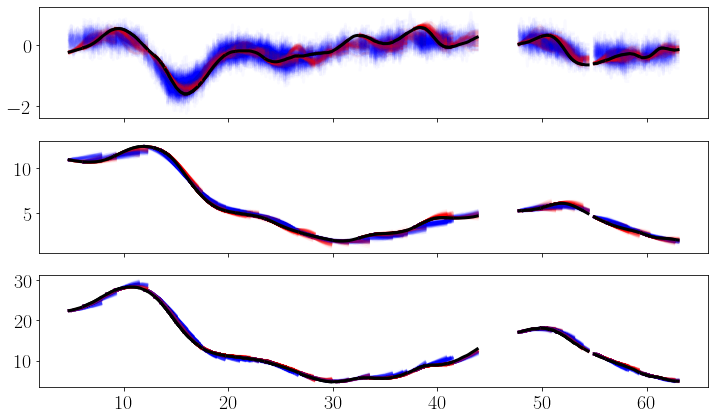

In [7]:
import pickle
from pickle import UnpicklingError
import os
from os import path
import sys
import numpy as np

import scipy
import CRPS.CRPS as pscore

sys.path.append('../')
from data.data_loader import read_training_data

import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel

sys.path.append('../')
from config import Config

np.random.seed(seed=1116)


def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a


def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt


def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt


def GP(X1, y1, X2, kernel_func):
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1) + 1e-6 * np.eye(X1.shape[0])
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12).T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance


id_veh = 11
sim_length = int(3 / Config.dt) + 1
tracks = read_training_data(base_path='../data/highD/', min_traj_lenth=50 * Config.frame_rate_orignial)

if id_veh <= 10:
    pair_id = Config.car_interactive_pair_list[id_veh - 1]
else:
    pair_id = Config.truck_interactive_pair_list[id_veh - 1 - 10]

N_total = tracks[pair_id]['xLeaderReal'].shape[0]


def simulate(tr, sample_idx, t0=0, print_values=False, mean=False, GP_flag=False):
    tracks = read_training_data(base_path='../data/highD/', min_traj_lenth=50 * Config.frame_rate_orignial)
    if id_veh <= 10:
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()
    else:
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()

    driver_para *= [33, 2, 1.6, 1.5, 1.67]
    DELTA = 4

    if print_values:
        print("Loading parameters for driver", str(pair_id))
        print(driver_para)

    x_leader, v_leader = tracks[pair_id]['xLeaderReal'][t0:t0 + sim_length], \
                         tracks[pair_id]['vLeaderReal'][t0:t0 + sim_length]

    x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'][t0:t0 + sim_length], \
                                                         tracks[pair_id]['vFollReal'][t0:t0 + sim_length], \
                                                         tracks[pair_id]['aFollReal'][t0:t0 + sim_length], \
                                                         tracks[pair_id]['vehicle_length'][t0:t0 + sim_length]

    s_real = tracks[pair_id]['sReal'][t0:t0 + sim_length]

    N = sim_length

    T = np.array(range(t0, t0 + N)) * Config.dt

    x_follower_temp = x_follower[0]
    v_follower_temp = v_follower[0]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[0] = v_follower_temp
    s_follower_sim[0] = s_real[0]

    if GP_flag:
        l = tr.posterior.l.mean(axis=0).mean(axis=0).to_numpy()
        sample_dim = int(3 * l)
        s_f = np.sqrt(tr.posterior.s2_f.mean(axis=0).mean(axis=0)).to_numpy()

        def RBF_kernel(XA, XB, l=l, A=s_f):
            X_dist = A ** 2 * rbf_kernel(XA[:, [0]], XB[:, [0]], gamma=0.5 / l ** 2)
            return X_dist

        X1 = np.expand_dims(np.linspace(-sample_dim, -1, sample_dim), 1)
        # y1 = np.zeros((sample_dim))
        y1 = tracks[pair_id]['aFollReal'][t0 - sample_dim:t0] - \
             IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA,
                   tracks[pair_id]['sReal'][t0 - sample_dim:t0], tracks[pair_id]['vFollReal'][t0 - sample_dim:t0],
                   tracks[pair_id]['vFollReal'][t0 - sample_dim:t0] - tracks[pair_id]['vLeaderReal'][
                                                                      t0 - sample_dim:t0])
        X2 = np.expand_dims(np.linspace(0, 1, 2), 1)

    for t in range(1, N):
        x_leader_temp = x_leader[t - 1]
        v_leader_temp = v_leader[t - 1]

        s = x_leader_temp - x_follower_temp - vehicle_length[t - 1]
        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp

        if GP_flag:
            μ2, Σ2 = GP(X1, y1, X2, RBF_kernel)
            a_GP_sim = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=1)
            a_GP_sim_temp = a_GP_sim[0, 0] + np.random.normal(0, np.sqrt(tr.posterior.s2_a.mean(axis=0).mean(axis=0)))
        else:
            a_GP_sim_temp = np.random.normal(0, tr_B.posterior.s_a.mean())

        a_follower_temp = a_GP_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3],
                                                driver_para[4], DELTA, s, vt, dv)
        v_follower_temp = IDM_v(a_follower_temp, vt)
        x_follower_temp = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t - 1] = a_follower_temp

        if GP_flag:
            y1[:-1] = y1[1:]
            y1[-1] = a_GP_sim[0, 0]

    a_follower_sim[-1] = a_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T


base_path = '../data/highD/'

cache = "../PGM_highD/cache/MA_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_GP = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

cache = "../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_B = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

################
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(12, 7))
linewidth = 3.
linewidth_mean = 2
linewidth_gt = 5
color_sim = 'red'
color_sim_mean = 'yellow'
color_sim_B = 'blue'
color_sim_mean_B = 'fuchsia'
color_sim_gt = 'k'
alpha = 0.03
################

print_values = False
sample_num = 50
sample_num_t = 50

RMSE_ACC_GP = np.zeros(sample_num * sample_num_t)
RMSE_VEL_GP = np.zeros(sample_num * sample_num_t)
RMSE_GAP_GP = np.zeros(sample_num * sample_num_t)
RMSE_ACC_B = np.zeros(sample_num * sample_num_t)
RMSE_VEL_B = np.zeros(sample_num * sample_num_t)
RMSE_GAP_B = np.zeros(sample_num * sample_num_t)
crps_a_GP = np.zeros(sample_num_t)
crps_v_GP = np.zeros(sample_num_t)
crps_s_GP = np.zeros(sample_num_t)
crps_a_B = np.zeros(sample_num_t)
crps_v_B = np.zeros(sample_num_t)
crps_s_B = np.zeros(sample_num_t)

tracks = [None] * sample_num * sample_num_t

counter = 0
counter_t = 0
for t in np.random.choice(range(int(4 / Config.dt), N_total - sim_length), sample_num_t, replace=False):
    for sample_idx in np.random.choice(range(2000), sample_num, replace=False):  # range(sample_num):#
        a_follower_sim_GP, a_follower, v_follower_sim_GP, v_follower, \
        s_follower_sim_GP, s_real, T = simulate(tr_GP, sample_idx, t, print_values, mean=True, GP_flag=True)
        a_follower_sim_B, _, v_follower_sim_B, _, s_follower_sim_B, _, _ = simulate(tr_B, sample_idx, t, print_values,
                                                                                    mean=True)

        RMSE_ACC_GP[counter] = np.sqrt(mean_squared_error(a_follower_sim_GP, a_follower))
        RMSE_VEL_GP[counter] = np.sqrt(mean_squared_error(v_follower_sim_GP, v_follower))
        RMSE_GAP_GP[counter] = np.sqrt(mean_squared_error(s_follower_sim_GP, s_real))

        RMSE_ACC_B[counter] = np.sqrt(mean_squared_error(a_follower_sim_B, a_follower))
        RMSE_VEL_B[counter] = np.sqrt(mean_squared_error(v_follower_sim_B, v_follower))
        RMSE_GAP_B[counter] = np.sqrt(mean_squared_error(s_follower_sim_B, s_real))

        tracks[counter] = {
            'a_follower_sim_GP': a_follower_sim_GP,
            'v_follower_sim_GP': v_follower_sim_GP,
            's_follower_sim_GP': s_follower_sim_GP,
            'a_follower_sim_B': a_follower_sim_B,
            'v_follower_sim_B': v_follower_sim_B,
            's_follower_sim_B': s_follower_sim_B,
            'RMSE_ACC_GP': np.sqrt(mean_squared_error(a_follower_sim_GP, a_follower)),
            'RMSE_VEL_GP': np.sqrt(mean_squared_error(v_follower_sim_GP, v_follower)),
            'RMSE_GAP_GP': np.sqrt(mean_squared_error(s_follower_sim_GP, s_real)),
            'RMSE_ACC_B': np.sqrt(mean_squared_error(a_follower_sim_B, a_follower)),
            'RMSE_VEL_B': np.sqrt(mean_squared_error(v_follower_sim_B, v_follower)),
            'RMSE_GAP_B': np.sqrt(mean_squared_error(s_follower_sim_B, s_real)),
        }

        counter += 1
        # if counter % 100 == 0:
        #     print("Simulation:", counter, "/", sample_num * sample_num_t)

        plt.subplot(3, 1, 1)
        plt.plot(T, a_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=.8 * alpha)
        plt.plot(T, a_follower_sim_GP, '-', color=color_sim, linewidth=0.8 * linewidth,
                 alpha=2 * alpha)

        plt.subplot(3, 1, 2)
        plt.plot(T, v_follower_sim_GP, '-', color=color_sim, linewidth=linewidth, alpha=alpha)
        plt.plot(T, v_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=alpha)

        plt.subplot(3, 1, 3)
        plt.plot(T, s_follower_sim_GP, '-', color=color_sim, linewidth=linewidth, alpha=alpha)
        plt.plot(T, s_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=alpha)

    plt.subplot(3, 1, 1)
    plt.plot(T, a_follower, '-', color='k', linewidth=linewidth)

    plt.subplot(3, 1, 2)
    plt.plot(T, v_follower, '-', color='k', linewidth=linewidth)

    plt.subplot(3, 1, 3)
    plt.plot(T, s_real, '-', color='k', linewidth=linewidth)

    a_follower_sim_GP_temp = np.zeros((sample_num, sim_length))
    v_follower_sim_GP_temp = np.zeros((sample_num, sim_length))
    s_follower_sim_GP_temp = np.zeros((sample_num, sim_length))
    a_follower_sim_B_temp = np.zeros((sample_num, sim_length))
    v_follower_sim_B_temp = np.zeros((sample_num, sim_length))
    s_follower_sim_B_temp = np.zeros((sample_num, sim_length))

    for countt in range(counter - sample_num, counter):  # range(sample_num):#
        a_follower_sim_GP_temp[countt - counter + sample_num, :] = tracks[countt]['a_follower_sim_GP']
        v_follower_sim_GP_temp[countt - counter + sample_num, :] = tracks[countt]['v_follower_sim_GP']
        s_follower_sim_GP_temp[countt - counter + sample_num, :] = tracks[countt]['s_follower_sim_GP']
        a_follower_sim_B_temp[countt - counter + sample_num, :] = tracks[countt]['a_follower_sim_B']
        v_follower_sim_B_temp[countt - counter + sample_num, :] = tracks[countt]['v_follower_sim_B']
        s_follower_sim_B_temp[countt - counter + sample_num, :] = tracks[countt]['s_follower_sim_B']

    temp_crps_a_GP = np.zeros(sim_length)
    temp_crps_v_GP = np.zeros(sim_length)
    temp_crps_s_GP = np.zeros(sim_length)
    temp_crps_a_B = np.zeros(sim_length)
    temp_crps_v_B = np.zeros(sim_length)
    temp_crps_s_B = np.zeros(sim_length)

    for tt in range(sim_length):
        temp_crps_a_GP[tt], _, _ = pscore(a_follower_sim_GP_temp[:, tt], a_follower[tt]).compute()
        temp_crps_v_GP[tt], _, _ = pscore(v_follower_sim_GP_temp[:, tt], v_follower[tt]).compute()
        temp_crps_s_GP[tt], _, _ = pscore(s_follower_sim_GP_temp[:, tt], s_real[tt]).compute()
        temp_crps_a_B[tt], _, _ = pscore(a_follower_sim_B_temp[:, tt], a_follower[tt]).compute()
        temp_crps_v_B[tt], _, _ = pscore(v_follower_sim_B_temp[:, tt], v_follower[tt]).compute()
        temp_crps_s_B[tt], _, _ = pscore(s_follower_sim_B_temp[:, tt], s_real[tt]).compute()

    crps_a_GP[counter_t] = temp_crps_a_GP.mean()
    crps_v_GP[counter_t] = temp_crps_v_GP.mean()
    crps_s_GP[counter_t] = temp_crps_s_GP.mean()
    crps_a_B[counter_t] = temp_crps_a_B.mean()
    crps_v_B[counter_t] = temp_crps_v_B.mean()
    crps_s_B[counter_t] = temp_crps_s_B.mean()

    counter_t += 1
    if counter_t % 10 ==0:
        print('Simulation at time point:', counter_t, '/', sample_num_t)

print("RMSE_ACC_GP samples", RMSE_ACC_GP.mean())
print("RMSE_VEL_GP samples", RMSE_VEL_GP.mean())
print("RMSE_GAP_GP samples", RMSE_GAP_GP.mean())

print("RMSE_ACC_GP samples std", RMSE_ACC_GP.std())
print("RMSE_VEL_GP samples std", RMSE_VEL_GP.std())
print("RMSE_GAP_GP samples std", RMSE_GAP_GP.std())

print("RMSE_ACC_B samples", RMSE_ACC_B.mean())
print("RMSE_VEL_B samples", RMSE_VEL_B.mean())
print("RMSE_GAP_B samples", RMSE_GAP_B.mean())

print("RMSE_ACC_B samples std", RMSE_ACC_B.std())
print("RMSE_VEL_B samples std", RMSE_VEL_B.std())
print("RMSE_GAP_B samples std", RMSE_GAP_B.std())

print("crps_a_GP:", crps_a_GP.mean())
print("crps_v_GP:", crps_v_GP.mean())
print("crps_s_GP:", crps_s_GP.mean())
print("crps_a_B:", crps_a_B.mean())
print("crps_v_B:", crps_v_B.mean())
print("crps_s_B:", crps_s_B.mean())

print("crps_a_GP std:", crps_a_GP.std())
print("crps_v_GP std:", crps_v_GP.std())
print("crps_s_GP std:", crps_s_GP.std())
print("crps_a_B std:", crps_a_B.std())
print("crps_v_B std:", crps_v_B.std())
print("crps_s_B std:", crps_s_B.std())

plt.show()